# SCDAA Group Assignment 2024

Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch

## Exercise 2

### Exercise 2.1

In [6]:
import torch.nn as nn
import torch.optim as optim

class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

Epoch [100/500], Loss: 23.6450
Epoch [200/500], Loss: 4.6037
Epoch [300/500], Loss: 2.4075
Epoch [400/500], Loss: 0.7784
Epoch [500/500], Loss: 0.3016


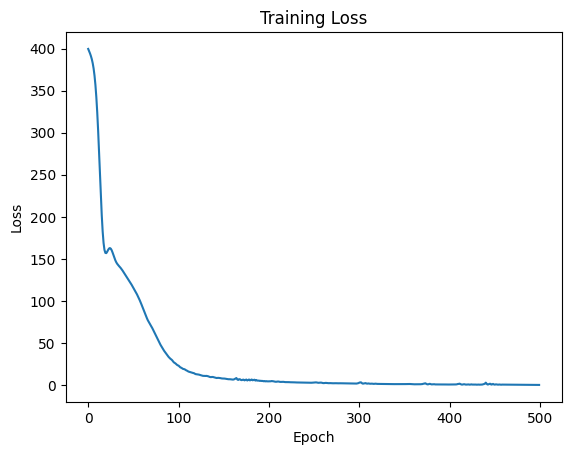

In [7]:
# Instantiate the network
# Instantiate the network for DGM
net_dgm = Net_DGM(dim_x=2, dim_S=100).float()

# Generate training data
num_samples = 1000  # Number of samples for training data
t_samples = (torch.rand(num_samples) * lqr_problem.T).float()  # Sampling t uniformly in [0, T]
x_samples = (torch.rand(num_samples, 2) * 6 - 3).float()  # Sampling x uniformly in [-3, 3] x [-3, 3]
#print(t_samples.shape)
#print(x_samples.shape)
value_function_data = lqr_problem.compute_value_function(t_samples, x_samples).float()

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(net_dgm.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 500  # Number of epochs for training
training_losses = []

# Training loop
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass to get output/logits
    x_reshaped = x_samples.reshape(-1, 2)
    outputs = net_dgm.forward(t_samples.unsqueeze(1), x_reshaped)

    # Calculate loss
    loss = criterion(outputs, value_function_data)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Record and print the training loss
    training_losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, plot the training loss
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

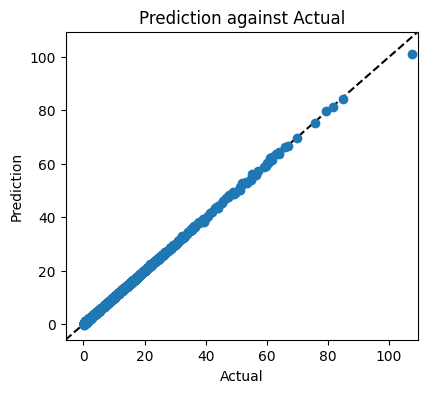

In [8]:
# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(value_function_data.detach().numpy(), outputs.detach().numpy())
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()

### Exercise 2.2

In [9]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).float())
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).float()

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).float()

Epoch [100/500], Control Loss: 6.8433
Epoch [200/500], Control Loss: 4.3922
Epoch [300/500], Control Loss: 2.6025
Epoch [400/500], Control Loss: 1.8526
Epoch [500/500], Control Loss: 1.1936


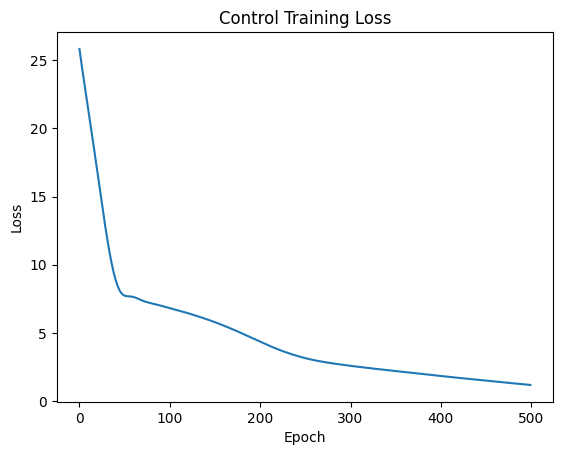

In [10]:
# Generate training data for Markov control
control_targets = lqr_problem.compute_markov_control(t_samples, x_samples).float()

# Instantiate the neural network for Markov control
control_network = FFN(sizes = [1 + 2, 100, 100, 2]).float()

# Loss function and optimizer for the control network
control_criterion = nn.MSELoss()  # Mean squared error loss
control_optimizer = optim.Adam(control_network.parameters(), lr=0.001)  # Adam optimizer

control_training_losses = []

# Training loop for the control network
for epoch in range(num_epochs):
    # Zero the parameter gradients
    control_optimizer.zero_grad()

    x_reshaped = x_samples.reshape(-1, 2)

    # Prepare the inputs to the network (concatenating t and x)
    control_inputs = torch.cat((t_samples.unsqueeze(1), x_reshaped), dim=1)

    # Forward pass to get output/logits
    control_outputs = control_network.forward(control_inputs)

    # Calculate loss
    control_loss = control_criterion(control_outputs, control_targets)

    # Backward pass and optimize
    control_loss.backward()
    control_optimizer.step()

    # Record and print the training loss
    control_training_losses.append(control_loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Control Loss: {control_loss.item():.4f}')

# After training, plot the training loss for the control network
plt.plot(control_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Control Training Loss')
plt.show()


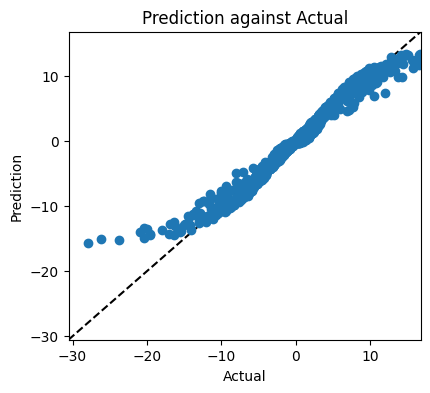

In [11]:
# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(control_targets.detach().numpy(), control_outputs.detach().numpy())
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()

## Exercise 3

### Exercise 3.1

Epoch 0, Loss: 4745.27685546875
Epoch 100, Loss: 473.302734375
Epoch 200, Loss: 71.34652709960938
Epoch 300, Loss: 32.90209197998047
Epoch 400, Loss: 11.726319313049316
Epoch 500, Loss: 5.64765739440918
Epoch 600, Loss: 4.550130367279053
Epoch 700, Loss: 2.570843458175659
Epoch 800, Loss: 2.1925153732299805
Epoch 900, Loss: 1.1958836317062378


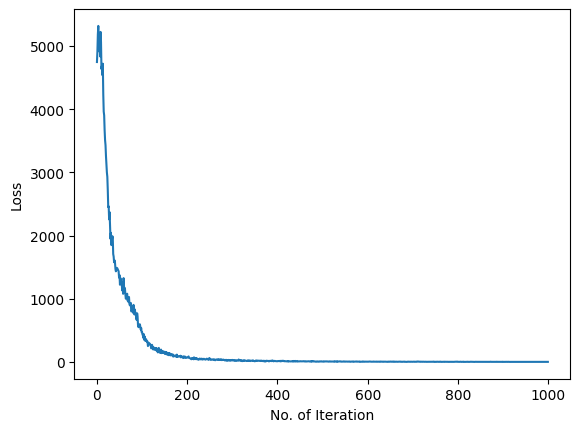

In [16]:
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output


#import tqdm

def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hessian(grad, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1], dtype=torch.float32)
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
    return hessian


class PDE_DGM(torch.nn.Module):
    def __init__(self, net, T, H, M, C, D, R, sigma, alpha):
        super().__init__()
        self.net = net
        self.T = T
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma  # assuming sigma is already a tensor with the correct shape
        self.sigma_sigma_t = sigma @ sigma.T  # do not re-wrap in torch.tensor
        self.alpha = alpha.view(2, 1)  # assuming alpha is already a tensor, use view to reshape
        self.M_alpha = self.M @ self.alpha
        self.a_D_a = self.alpha.T @ self.D @ self.alpha

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = (10000,) ,gamma=0.1)
        loss_fn = torch.nn.MSELoss()

        # Train model
        #pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            
            t_tensor = torch.tensor(np.random.uniform(low=0, high=lqr_problem.T, size=batch_size), requires_grad=True).unsqueeze(1).float()
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True).float()
            u_of_tx = self.net(t_tensor, x_tensor)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            M_alpha_grad = torch.matmul(grad_u_x,self.M_alpha)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + self.a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1, dtype=torch.float32) * lqr_problem.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)), dtype=torch.float32)
            u_of_tx_terminal = self.net(t_tensor_terminal, x_tensor_terminal)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx_terminal, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                print(f'Epoch {iter}, Loss: {loss.item()}')

        if plot:
            # Plot training loss graph
            plt.plot(losses)
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            # print(losses)
            
    def forward(self, t_tensor, x_tensor):
        return self.net.forward(t_tensor, x_tensor).to(torch.float64)


net_dgm2 = Net_DGM(dim_x=2, dim_S=100).float()

H = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 0.1
M = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32)
C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
D = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32)
R = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 10
sigma = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 0.001
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)

dgm = PDE_DGM(net_dgm2, T, H, M, C, D, R, sigma, alpha)
batch_size = 1000
num_epochs = 1000
dgm.fit(batch_size, num_epochs, plot=True)

In [17]:
def simulate_dynamics_w_constant_control(alpha, t0, x0, N_steps, num_samples, sigma, H, M, C, D, R):
    dt = (T - t0) / N_steps
    costs_all_paths = []

    for _ in range(num_samples): 
        cost_path = 0.0
        # Ensure x is a two-dimensional column vector for state variables
        x = x0.clone().detach().view(2, 1)  # x0 needs to be reshaped to [2, 1] if it isn't already
        for step in range(N_steps):
            drift = (H @ x + M @ alpha.view(2, 1)) * dt
            dW = torch.randn(2, 1, dtype=torch.float32) * torch.sqrt(dt)
            x = x + drift + sigma @ dW  # Ensure this addition involves tensors of shape [2, 1]
            cost_path += (x.T @ C @ x + alpha.view(1, 2) @ D @ alpha.view(2, 1)) * dt

        cost_path += x.T @ R @ x  # The final cost

        costs_all_paths.append(cost_path.item())

    MC_value = np.mean(costs_all_paths)  # Use np.mean instead of np.average for consistency

    return MC_value

In [18]:
trained_network = dgm  # This is your trained model

# Assume alpha, H, M, C, D, R, sigma are defined as tensors with appropriate shapes
alpha = torch.tensor([1.0, 1.0])  # Example constant alpha vector
T = lqr_problem.T  # Total time
N_steps = 100  # Number of steps in the simulation
num_samples = 1000  # Number of Monte Carlo samples
x0 = torch.tensor([1.0, 1.0], dtype=torch.float32).view(2, 1)  # Initial condition of the system

# Run the simulation
t0 = torch.tensor([0.0], dtype=torch.float32)  # Start time
MC_value = simulate_dynamics_w_constant_control(alpha, t0, x0, N_steps, num_samples, sigma, H, M, C, D, R)

# Sampling points for comparison
t_val = torch.rand(num_samples, 1) * T
x_val = torch.rand(num_samples, 2) * 6 - 3  # Sampled uniformly between [-3, 3]

# Get the solution from the neural network for each time and space sample
with torch.no_grad():
    # Ensure that you split the concatenated tensor back into t and x before passing them to the network
    t_val = torch.rand(num_samples, 1) * T
    x_val = torch.rand(num_samples, 2) * 6 - 3  # Sampled uniformly between [-3, 3]
    tx_combined = torch.cat((t_val, x_val), dim=1)
    # Split the tensor into t and x components
    t_nn = tx_combined[:, :1]  # Assuming the first column is time
    x_nn = tx_combined[:, 1:]  # The rest are spatial dimensions
    # Pass the separated tensors to the trained network
    neural_net_solution = trained_network(t_nn, x_nn).view(-1).numpy()

# Generate Monte Carlo solutions for the same sampled points
mc_solutions = np.array([simulate_dynamics_w_constant_control(alpha, t_val[i], x_val[i], N_steps, 1, sigma, H, M, C, D, R)
                         for i in range(num_samples)])

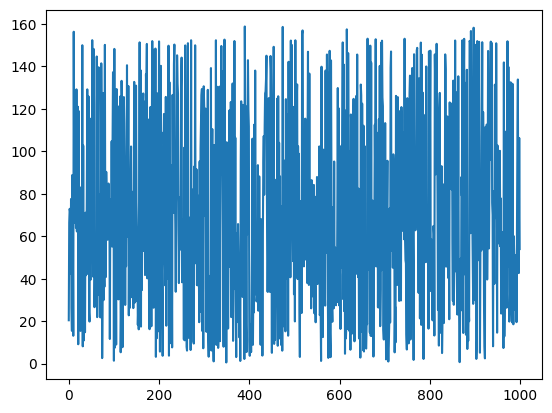

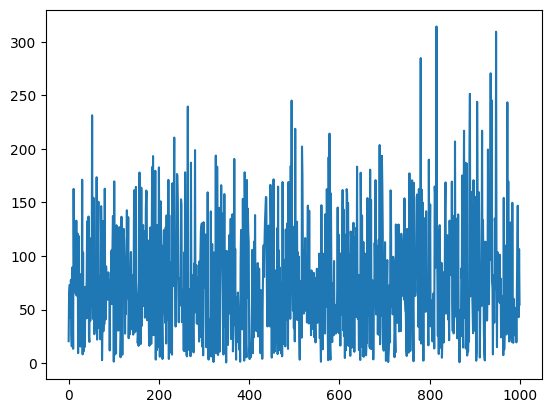

In [19]:
plt.plot(neural_net_solution)
plt.show()
plt.plot(mc_solutions)

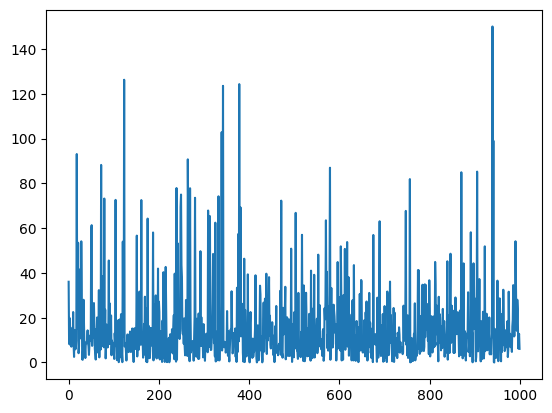

In [20]:
batch_size = 1000
random_t2 = (torch.rand(batch_size) * T)
random_x2 = torch.rand(batch_size, 2) * 6 - 3 
a_values = lqr_problem.compute_value_function(random_t2, random_x2).numpy()
a_values = a_values.flatten()
plt.plot(a_values)

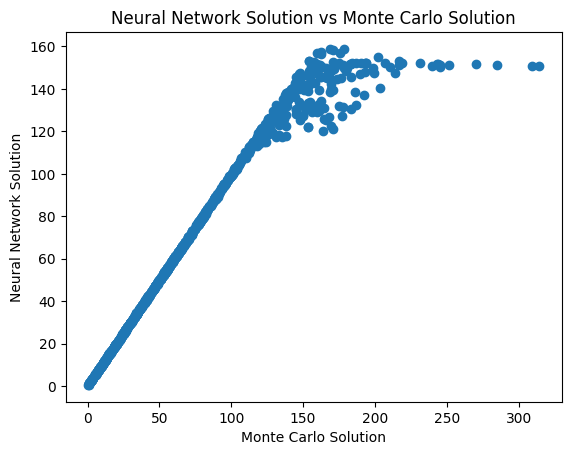

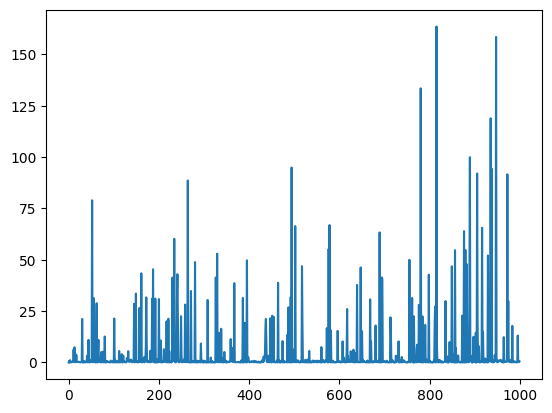

In [21]:
# Compute error at each sample point
error = np.abs(neural_net_solution - mc_solutions)
#error = error[::10]
# Visualization of neural network solution vs Monte Carlo solution
plt.figure()
plt.scatter(mc_solutions, neural_net_solution)
plt.xlabel('Monte Carlo Solution')
plt.ylabel('Neural Network Solution')
plt.title('Neural Network Solution vs Monte Carlo Solution')
plt.show()

plt.plot(error)
plt.show()

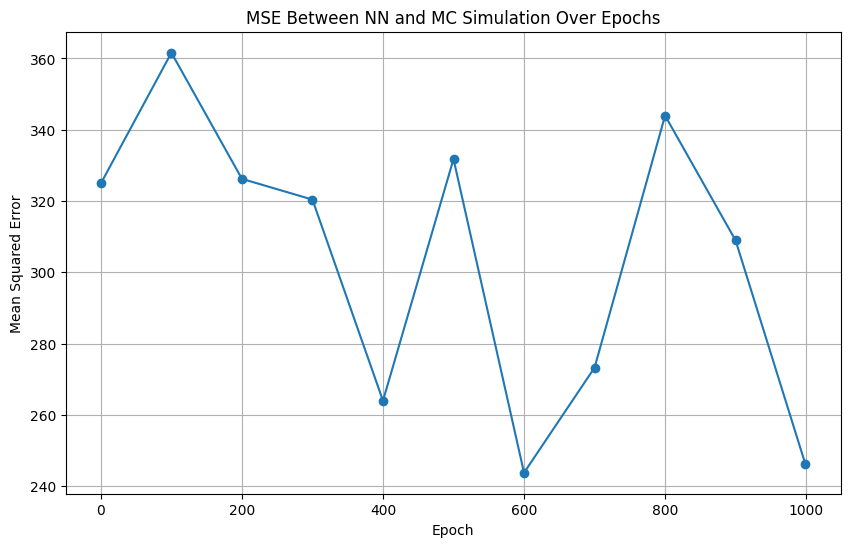

In [22]:
def train_and_evaluate_model(model, num_epochs, evaluation_interval):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epoch_errors = []  # Store average error per evaluation interval

    for epoch in range(num_epochs):
        # Perform training step
        # This is where you'd include your training code, e.g.,
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        if epoch % evaluation_interval == 0 or epoch == num_epochs - 1:
            #model.eval()  # Set the model to evaluation mode
            
            with torch.no_grad():
                total_error = 0
                
                # Here you can sample a fixed set of points for comparison
                t_val = torch.rand(num_samples, 1) * T
                x_val = torch.rand(num_samples, 2) * 6 - 3
                
                for i in range(num_samples):
                    nn_sol = model(t_val[i].unsqueeze(0), x_val[i].unsqueeze(0)).item()
                    mc_sol = simulate_dynamics_w_constant_control(alpha, t_val[i], x_val[i].view(2, 1), N_steps, 1, sigma, H, M, C, D, R)
                    
                    total_error += (nn_sol - mc_sol)**2
                
                ms_error = total_error / num_samples
                epoch_errors.append(ms_error)
            
            #model.train()  # Set the model back to training mode

    # Plotting error over epochs
    plt.figure(figsize=(10, 6))
    epochs_evaluated = list(range(0, num_epochs, evaluation_interval)) + [num_epochs - 1]
    plt.plot(epochs_evaluated, epoch_errors, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Between NN and MC Simulation Over Epochs')
    plt.grid(True)
    plt.show()

# Assuming 'dgm' is your model instance and other necessary variables (like 'T', 'alpha', etc.) are defined
train_and_evaluate_model(dgm, 1000, 100)